In [16]:
import numpy as np
import imp
import pickle
from scipy.stats import norm
import lmfit

In [2]:
# Initialise wrapper
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('../../Applications/SimplyC/simplyc_regional.dll')

# Calibration functions
calib_fpath = (r"..\mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

In [3]:


calib_locations = ['Langtjern', 'Storgama', 'Birkenes']

landuse_classes = ['Forest', 'Shrubbery', 'Bog']

landuse = {
    'Langtjern' : [73, 5,  22],
    'Storgama'  : [11, 67, 22],
    'Birkenes'  : [90, 3,  7],
}

In [4]:
#NOTE: Here the input file name is only used for structuring, which is fine. No input data is read in
#template_dataset = wr.DataSet.setup_with_blank_index_sets('../../Applications/SimplyC/Storgama/inputs_Storgama.dat')
#template_dataset.set_indexes('Landscape units', landuse_classes)
#template_dataset.set_branch_indexes('Reaches', [('R0', [])])
#template_dataset.set_parameter_uint('Timesteps', [], timesteps)
#template_dataset.set_parameter_time('Start date', [], start_date)
template_dataset = wr.DataSet.setup_from_parameter_and_input_files('template_pars.dat', 'template_inputs.dat')

#For now, just run all in 1986-01-01 to 2012-12-31 since it is tricky to have different ranges on them.
timesteps = template_dataset.get_parameter_uint('Timesteps', [])
start_date = template_dataset.get_parameter_time('Start date', [])

param_df = cu.get_double_parameters_as_dataframe(template_dataset)
param_df

,name,unit,index,min_value,initial_value,max_value
0,Latitude,°,(),-90.000000,60.600,9.000000e+01
1,Elevation,m,(),0.000000,0.000,8.848000e+03
2,PET multiplication factor,dimensionless,(),1.000000,1.280,2.000000e+00
3,Net emissivity at 0 vapor pressure,dimensionless,(),0.000000,0.340,1.000000e+00
4,Change in emissivity caused by vapor pressure,kPa^{-1/2},(),0.000000,0.139,5.000000e-01
5,Initial snow depth as water equivalent,mm,(),0.000000,0.000,5.000000e+04
6,Degree-day factor for snowmelt,mm/°C/day,(),0.000000,2.740,5.000000e+00
7,Snow melt offset temperature,°C,(),-4.000000,0.000,4.000000e+00
8,Temperature at which precipitation falls as snow,°C,(),-4.000000,0.000,4.000000e+00
9,Snow fall multiplier,dimensionless,(),0.500000,1.000,1.500000e+00


In [5]:
vars = [
    2, 6,                #hydrology
    10, 11,              #hydrology
    17, 18, 19,          #soil tc (hydrology)
    28,                  #soil temp
    30, 31, 32,          #soil temp
    33, 34,              #global carbon
    35, 36, 37,          #lu carbon
    38, 39, 40,          #lu carbon
]

calib_df = param_df.loc[vars].reset_index(drop=True)
calib_df

,name,unit,index,min_value,initial_value,max_value
0,PET multiplication factor,dimensionless,(),1.00,1.28,2.000
1,Degree-day factor for snowmelt,mm/°C/day,(),0.00,2.74,5.000
2,Proportion of precipitation that contributes t...,dimensionless,(),0.00,0.00,1.000
3,Soil field capacity,mm,(),0.00,100.00,1000.000
4,Soil water time constant,days,"(Forest,)",0.01,2.00,40.000
5,Soil water time constant,days,"(Shrubbery,)",0.01,2.00,40.000
6,Soil water time constant,days,"(Bog,)",0.01,2.00,40.000
7,Snow depth / soil temperature factor,/cm,(),-3.00,-0.20,-0.001
8,"Soil thermal conductivity (W/m/°C, range 0.4-0...",1E-6 m2/s,"(Forest,)",0.01,0.40,0.800
9,"Soil thermal conductivity (W/m/°C, range 0.4-0...",1E-6 m2/s,"(Shrubbery,)",0.01,0.40,0.800


In [6]:
# Add 'short_name' column for calibrating parameters
calib_df['short_name'] = [
    'alphaPET', 'DDFmelt',
    'fquick', 'fc',
    'Ts_F', 'Ts_S', 'Ts_B',
    'sdst', 'Stc_F', 'Stc_S', 'Stc_B',
    'kT', 'kSO4',
    'Cdiss_F', 'Cdiss_S', 'Cdiss_B',
    'DOCb_F', 'DOCb_S', 'DOCb_B',
]

In [8]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)


params['kT'].min = 0.0
params['kT'].max = 0.2

params['kSO4'].min = 0.0
params['kSO4'].max = 0.2

params['Stc_S'].set(expr='Stc_F')
params['Stc_B'].set(expr='Stc_F')

for lu in ['F', 'S', 'B'] :
    params['DOCb_%s' % lu].min = 1.0
    params['DOCb_%s' % lu].max = 14.0
    
    params['Cdiss_%s' % lu].max = 3.0

#TODO: see if this is ok:
params['Cdiss_S'].set(expr='Cdiss_F')
params['Cdiss_B'].set(expr='Cdiss_F')

#params['fquick'].min = 0.0
params['fquick'].max = 0.1

#params['Ts'].max = 5.0

params['alphaPET'].max = 3.0

params

         Consider setting (min < value < max) instead?


name,value,initial value,min,max,vary,expression
alphaPET,1.28000000,1.28,1.00000000,3.00000000,True,
DDFmelt,2.74000000,2.74,0.00000000,5.00000000,True,
fquick,0.00000000,0.0,0.00000000,0.10000000,True,
fc,100.000000,100.0,0.00000000,1000.00000,True,
Ts_F,2.00000000,2.0,0.01000000,40.0000000,True,
Ts_S,2.00000000,2.0,0.01000000,40.0000000,True,
Ts_B,2.00000000,2.0,0.01000000,40.0000000,True,
sdst,-0.20000000,-0.2,-3.00000000,-1.0000e-03,True,
Stc_F,0.40000000,0.4,0.01000000,0.80000000,True,
Stc_S,0.40000000,0.4,0.01000000,0.80000000,False,Stc_F


In [9]:
#These will be used to get physical data along with input time series:
initial_datasets = {}

for loc in calib_locations :
    parfile = '../../Applications/SimplyC/%s/params_%s_regional.dat' % (loc, loc)
    inpfile = '../../Applications/SimplyC/%s/inputs_%s.dat' % (loc, loc)
    initial_datasets[loc] = wr.DataSet.setup_from_parameter_and_input_files(parfile, inpfile)
    
    #NOTE: this is to make everything align up when copying input data below:
    initial_datasets[loc].set_parameter_uint('Timesteps', [], timesteps)
    initial_datasets[loc].set_parameter_time('Start date', [], start_date)

In [10]:
datasets = {}

for loc in calib_locations :
    dataset = template_dataset.copy()
        
    for par in ['Latitude', 'Elevation'] :
        dataset.set_parameter_double(par, [], initial_datasets[loc].get_parameter_double(par, []))
    
    for par in ['Reach length', 'Reach slope', 'Catchment area', 'Initial in-stream flow'] :
        dataset.set_parameter_double(par, ['R0'], initial_datasets[loc].get_parameter_double(par, [loc]))
    
    for idx, lu in enumerate(landuse_classes) :
        dataset.set_parameter_double('Land use proportions', ['R0', lu], landuse[loc][idx]*0.01)   #percentage to 0-1 range
        
    for inp in template_dataset.get_input_list() :
        name, _ = inp
        series = initial_datasets[loc].get_input_series(name, [], alignwithresults=True)
        dataset.set_input_series(name, [], series, alignwithresults=False)
    
    datasets[loc] = dataset

In [11]:
comparisons = [
                ('Reach flow (daily mean, cumecs)', ['R0'], 'Observed flow', []),
                ('Reach DOC concentration (volume weighted daily mean)', ['R0'], 'Observed DOC', []),
                #('DOC flux from reach, daily mean', 'DOC flux', True),
               ]

In [12]:
def normal_weight(series) :
    size = np.count_nonzero(~np.isnan(series))
    return series / np.sqrt(size)

# Custom residual function that takes into account yearly sums as well as daily values
def resid(params, datasets, comparisons, norm=False, skip_timesteps=0) :
    
    residuals = []
    
    for loc in calib_locations :
        
        dataset_copy = datasets[loc].copy()
        cu.set_parameter_values(params, dataset_copy)
        dataset_copy.run_model()

        for i, comparison in enumerate(comparisons):
            simname, simindexes, obsname, obsindexes = comparison

            sim = dataset_copy.get_result_series(simname, simindexes)[skip_timesteps:]
            obs = dataset_copy.get_input_series(obsname, obsindexes, alignwithresults=True)[skip_timesteps:]

            if np.isnan(sim).any() :
                raise ValueError('Got a NaN in the simulated data')

            resid = sim - obs

            #residuals.append(normal_weight(resid))
            residuals.append(resid)

        dataset_copy.delete()   
    
    return np.concatenate(residuals)

Location: Langtjern

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.005882
Mean absolute error: 0.012687
Root mean square error: 0.024595
Nash-Sutcliffe coefficient: 0.331504
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -4.360964
Mean absolute error: 4.390990
Root mean square error: 5.483071
Nash-Sutcliffe coefficient: -1.905484
Number of observations: 981

Location: Storgama

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.007021
Mean absolute error: 0.012823
Root mean square error: 0.027113
Nash-Sutcliffe coefficient: 0.323251
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): 0.242655
Mean absolute error: 1.247040
Root mean square error: 1.523052
Nash-Sutcliffe coefficient: -0.143818

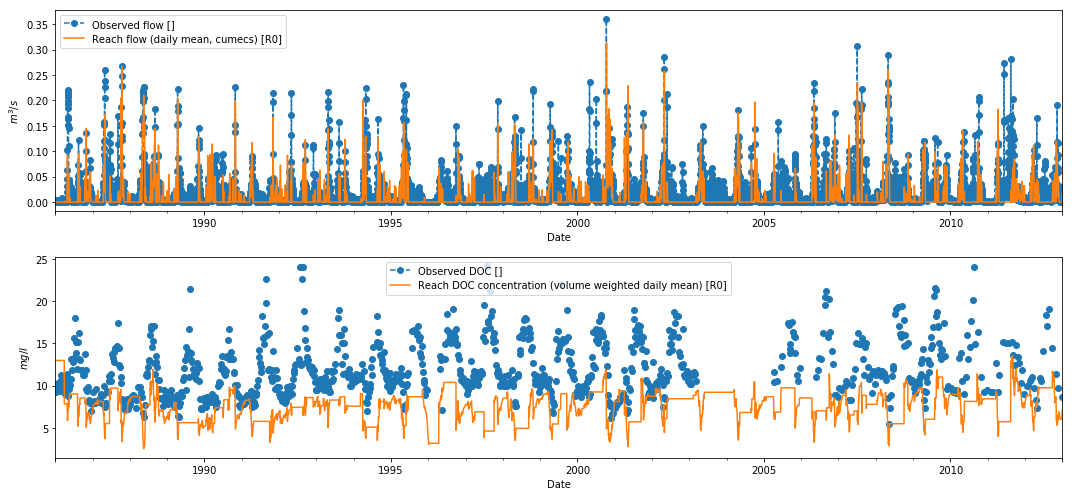

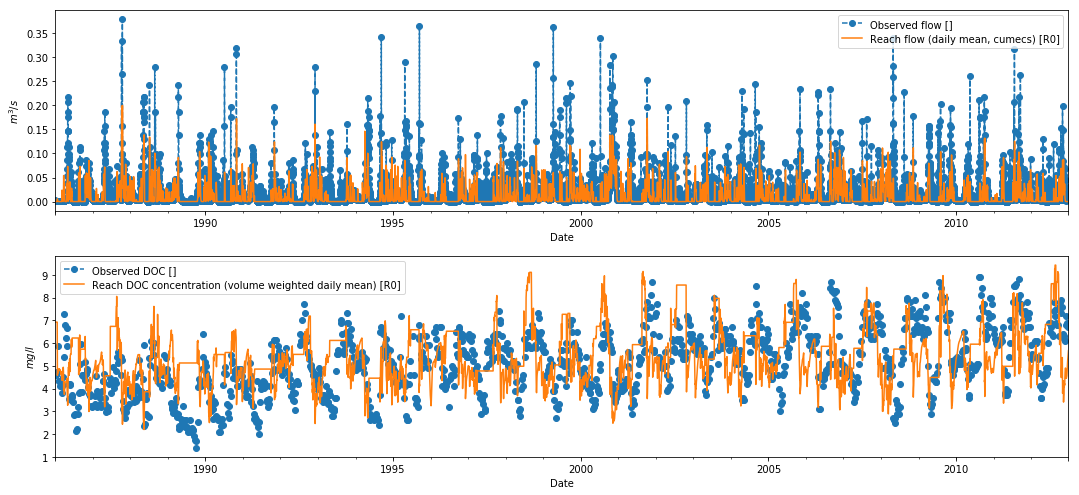

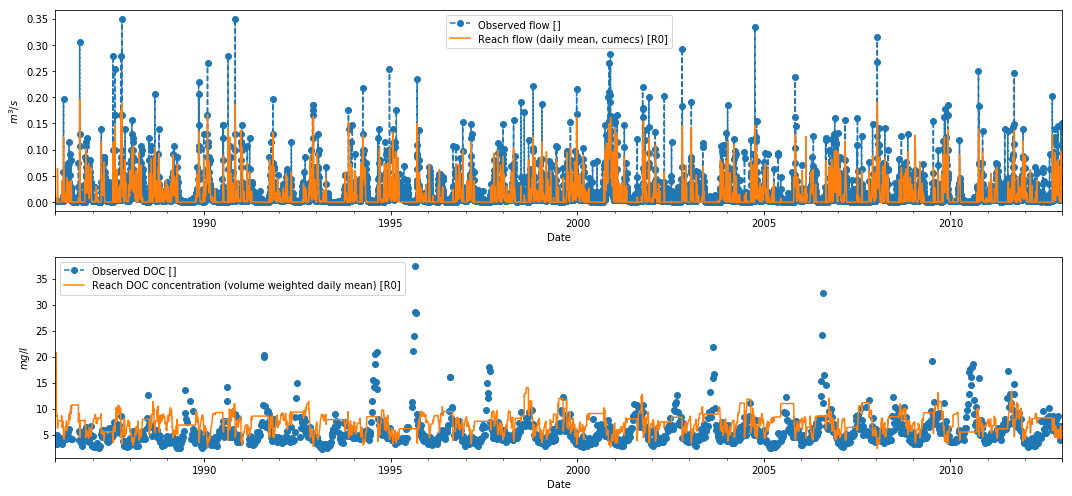

In [13]:
for loc in calib_locations :
    datasets[loc].run_model()
    print('Location: %s' % loc)
    cu.print_goodness_of_fit(datasets[loc], comparisons, skip_timesteps=365)
    cu.plot_objective(datasets[loc], comparisons)

In [14]:
def iter_cb(params, iter, resid, *args, **kws) :
    if iter % 10 == 0 :
        print('Iteration: %d, residual: %g' % (iter, np.nansum(resid*resid)) )
        #params.pretty_print(precision=3)

In [15]:
%%time

mi, res = cu.minimize_residuals(params, datasets, comparisons, residual_method=resid, method='leastsq', iter_cb=iter_cb, norm=False, 
                                skip_timesteps=365)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Iteration: 0, residual: 52292.7
Iteration: 10, residual: 52292.7
Iteration: 20, residual: 50256.1
Iteration: 30, residual: 50256.1
Iteration: 40, residual: 49940.3
Iteration: 50, residual: 49940.3
Iteration: 60, residual: 49351.8
Iteration: 70, residual: 48318
Iteration: 80, residual: 48318
Iteration: 90, residual: 46517.2
Iteration: 100, residual: 43803.1
Iteration: 110, residual: 43803.1
Iteration: 120, residual: 40718.7
Iteration: 130, residual: 40718.7
Iteration: 140, residual: 39751.9
Iteration: 150, residual: 38052.3
Iteration: 160, residual: 38052.3
Iteration: 170, residual: 36500
Iteration: 180, residual: 40103.1
Iteration: 190, residual: 36015.2
Iteration: 200, residual: 35746.5
Iteration: 210, residual: 35746.7
Iteration: 220, residual: 35690.7
Iteration: 230, residual: 35592.4
Iteration: 240, residual: 35592.4
Iteration: 250, residual: 35553.5
Iteration: 260, residual: 35553.6
Iteration: 270, residual: 35515.9
Iteration: 280, residual: 35495.3
Iteration: 290, residual: 35495

NameError: name 'lmfit' is not defined

In [17]:
print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 636
    # data points      = 32104
    # variables        = 15
    chi-square         = 34920.0944
    reduced chi-square = 1.08822632
    Akaike info crit   = 2729.36218
    Bayesian info crit = 2855.01322
[[Variables]]
    alphaPET:  1.25992202 +/- 2.1564e-04 (0.02%) (init = 1.28)
    DDFmelt:   2.69508879 +/- 0.00214609 (0.08%) (init = 2.74)
    fquick:    4.2325e-11 +/- 1.6959e-12 (4.01%) (init = 0)
    fc:        110.425469 +/- 0.01147917 (0.01%) (init = 100)
    Ts_F:      1.67058133 +/- 0.01548271 (0.93%) (init = 2)
    Ts_S:      2.04923345 +/- 0.00335509 (0.16%) (init = 2)
    Ts_B:      1.96181781 +/- 0.00304762 (0.16%) (init = 2)
    sdst:     -1.38301830 +/- 0.35805153 (25.89%) (init = -0.2)
    Stc_F:     0.10987313 +/- 0.00574421 (5.23%) (init = 0.4)
    Stc_S:     0.10987313 +/- 0.00574421 (5.23%) == 'Stc_F'
    Stc_B:     0.10987313 +/- 0.00574421 (5.23%) == 'Stc_F'
    k

Location: Langtjern

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.005963
Mean absolute error: 0.012815
Root mean square error: 0.024759
Nash-Sutcliffe coefficient: 0.322578
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -3.257767
Mean absolute error: 3.381995
Root mean square error: 4.184118
Nash-Sutcliffe coefficient: -0.691915
Number of observations: 981

Location: Storgama

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.007053
Mean absolute error: 0.012821
Root mean square error: 0.027119
Nash-Sutcliffe coefficient: 0.322914
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -0.222311
Mean absolute error: 1.091343
Root mean square error: 1.355190
Nash-Sutcliffe coefficient: 0.094418

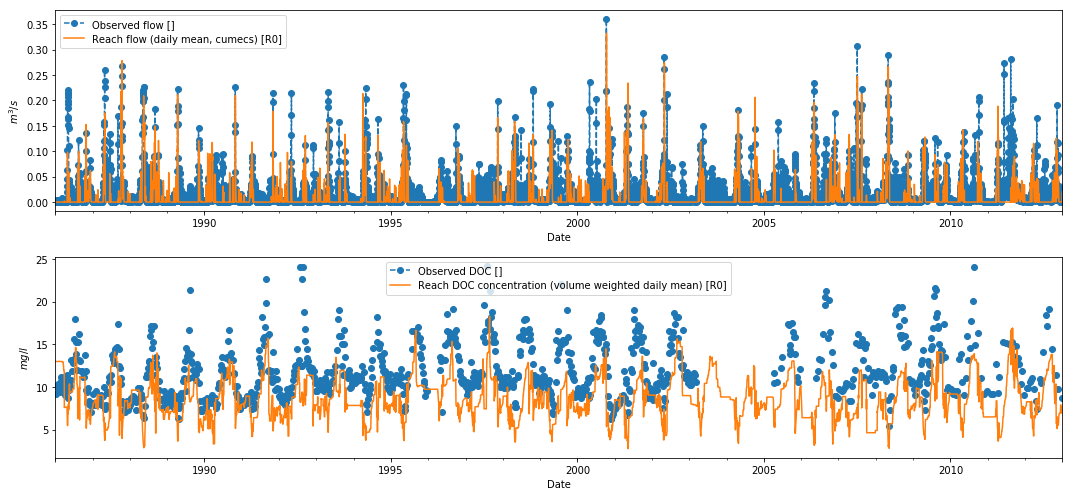

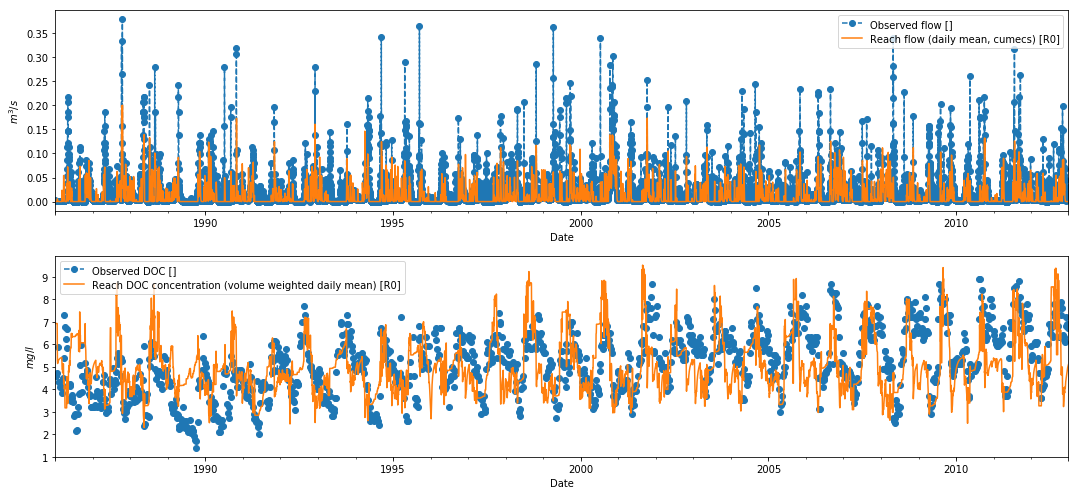

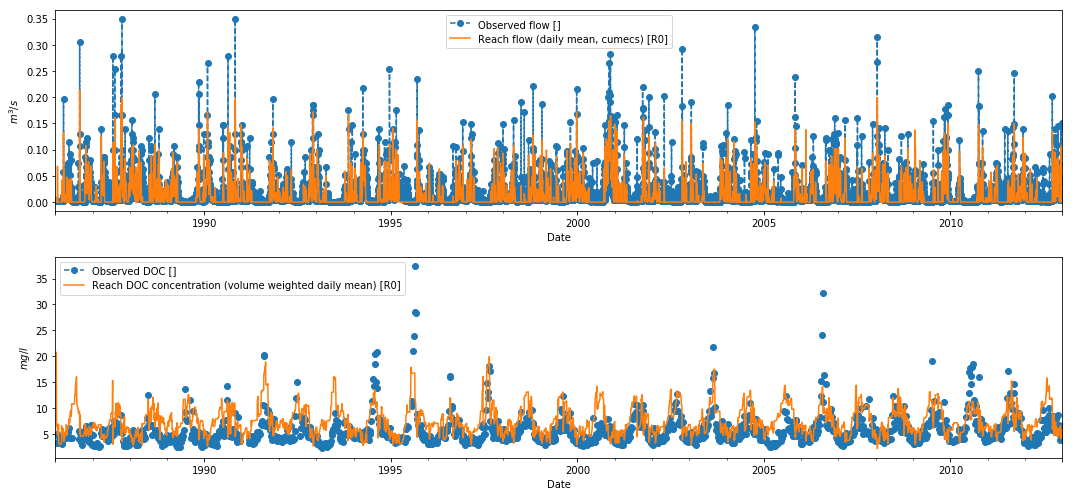

In [18]:
for loc in calib_locations :
    cu.set_parameter_values(res.params, datasets[loc])
    datasets[loc].run_model()
    print('Location: %s' % loc)
    cu.print_goodness_of_fit(datasets[loc], comparisons, skip_timesteps=365)
    cu.plot_objective(datasets[loc], comparisons)

In [19]:
datasets['Langtjern'].write_parameters_to_file('optimal1.dat')